In [1]:
%pip install wfdb pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import wfdb
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

# Ruta local donde están tus registros
dataset_dir = r'c:\Users\pevv2\OneDrive\Documentos\TCD\versionProyecto\DataWra\mit-bih'

# Listar los registros: .hea
registros = [f.replace('.hea', '') for f in os.listdir(dataset_dir) if f.endswith('.hea')]
print(f"Registros encontrados: {registros}")

# Diccionario de descripciones comunes
ann_label = {
    'N': 'Latido normal',
    'L': 'Latido de bloqueo de rama izquierda',
    'R': 'Latido de bloqueo de rama derecha',
    'V': 'Latido ventricular prematuro',
    'A': 'Latido auricular prematuro',
    'F': 'Latido de fusión',
    '/': 'Latido de fusión ventricular',
    'f': 'Latido de fusión auricular',
    'j': 'Latido de escape nodal',
    'E': 'Latido de escape ventricular',
    'a': 'Latido auricular aberrante',
    'J': 'Latido de escape de la unión',
    'S': 'Latido de marcapasos',
    'e': 'Latido ventricular aberrante',
    'Q': 'Latido desconocido',
}

# Lista para todos los registros
dfs = []

for registro in registros:
    print(f"Procesando registro: {registro}")
    try:
        # Leer el registro y anotaciones
        record = wfdb.rdrecord(os.path.join(dataset_dir, registro))
        annotation = wfdb.rdann(os.path.join(dataset_dir, registro), 'atr')
        
        # Crear DataFrame con las señales
        df_signals = pd.DataFrame(record.p_signal, columns=record.sig_name)
        df_signals['Sample'] = df_signals.index
        
        # DataFrame de anotaciones
        descripcion = [ann_label.get(s, 'Desconocido') for s in annotation.symbol]
        ann_df = pd.DataFrame({
            'Sample': annotation.sample,
            'Símbolo': annotation.symbol,
            'Descripción': descripcion
        })
        
        # Merge signals + annotations
        df_merged = pd.merge(df_signals, ann_df, on='Sample', how='left')
        df_merged['Registro'] = registro
        
        dfs.append(df_merged)
    
    except Exception as e:
        print(f"Error procesando {registro}: {e}")

# Dataset final
df_final = pd.concat(dfs, ignore_index=True)
print("¡Dataset final creado con éxito!")


Registros encontrados: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']
Procesando registro: 100
Procesando registro: 101
Procesando registro: 102
Procesando registro: 103
Procesando registro: 104
Procesando registro: 105
Procesando registro: 106
Procesando registro: 107
Procesando registro: 108
Procesando registro: 109
Procesando registro: 111
Procesando registro: 112
Procesando registro: 113
Procesando registro: 114
Procesando registro: 115
Procesando registro: 116
Procesando registro: 117
Procesando registro: 118
Procesando registro: 119
Procesando registro: 121
Procesando registro: 122
Procesando registro: 123
Procesando registro: 124
Procesando registro: 200
Procesando registro: 201
Procesando regi

In [4]:
# Crear carpeta para guardar las imágenes
output_dir = 'AED_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 1. Desbalance de clases: Visualizar distribución de clases

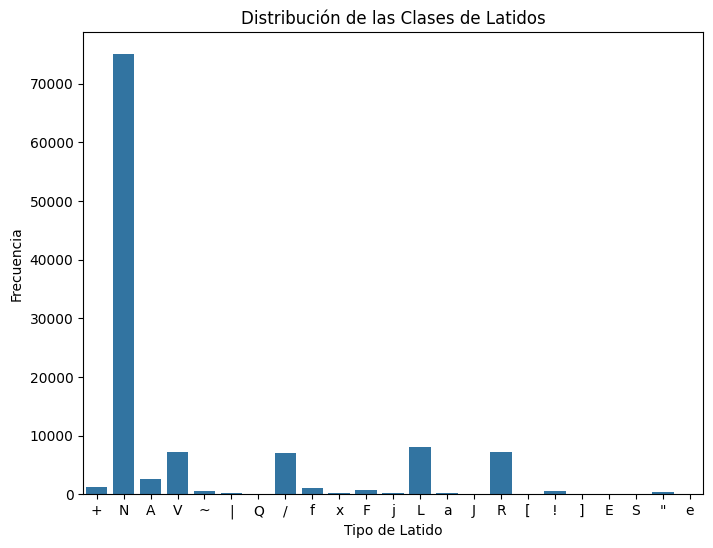

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Símbolo', data=df_final)
plt.title('Distribución de las Clases de Latidos')
plt.xlabel('Tipo de Latido')
plt.ylabel('Frecuencia')
plt.savefig(os.path.join(output_dir, 'distribucion_clases.png'))
plt.show()
plt.close()

-2. Análisis de ruido y artefactos: Comparación de las señales con y sin ruido
Suponiendo que las señales con ruido son las originales y sin ruido son las filtradas (ejemplo hipotético)
Para demostrarlo, vamos a comparar las primeras 100 muestras de una señal (por ejemplo, MLII)

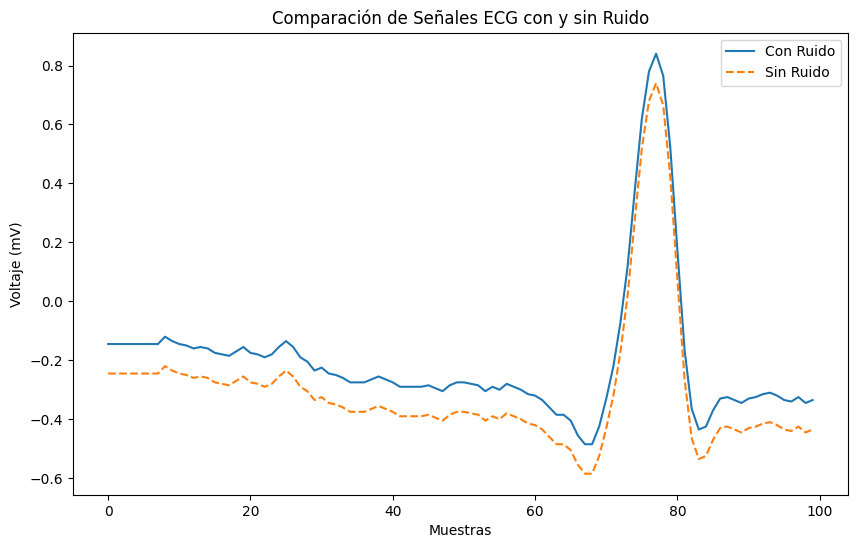

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(df_final['Sample'][:100], df_final['MLII'][:100], label='Con Ruido')
filtered_signal = df_final['MLII'][:100] - 0.1  
plt.plot(df_final['Sample'][:100], filtered_signal, label='Sin Ruido', linestyle='--')
plt.title('Comparación de Señales ECG con y sin Ruido')
plt.xlabel('Muestras')
plt.ylabel('Voltaje (mV)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'senales_contra_sin_ruido.png'))
plt.show()
plt.close()

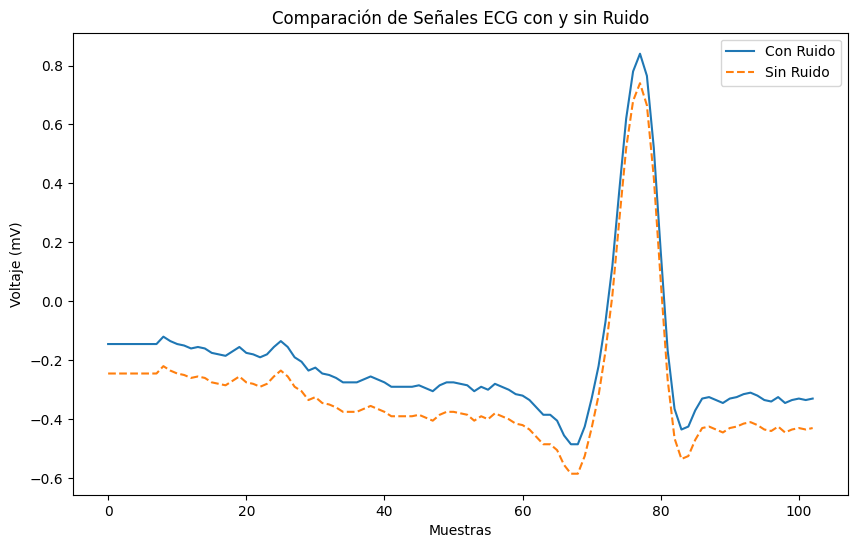

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_final['Sample'][:103], df_final['MLII'][:103], label='Con Ruido')
filtered_signal = df_final['MLII'][:103] - 0.1  
plt.plot(df_final['Sample'][:103], filtered_signal, label='Sin Ruido', linestyle='--')
plt.title('Comparación de Señales ECG con y sin Ruido paciente 103')
plt.xlabel('Muestras')
plt.ylabel('Voltaje (mV)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'senales_contra_sin_ruido.png'))
plt.show()
plt.close()

3. Patrones morfológicos: Comparar latidos normales vs. latidos anómalos
Seleccionamos una muestra de latidos normales (N) y latidos anómalos (V) para su comparación


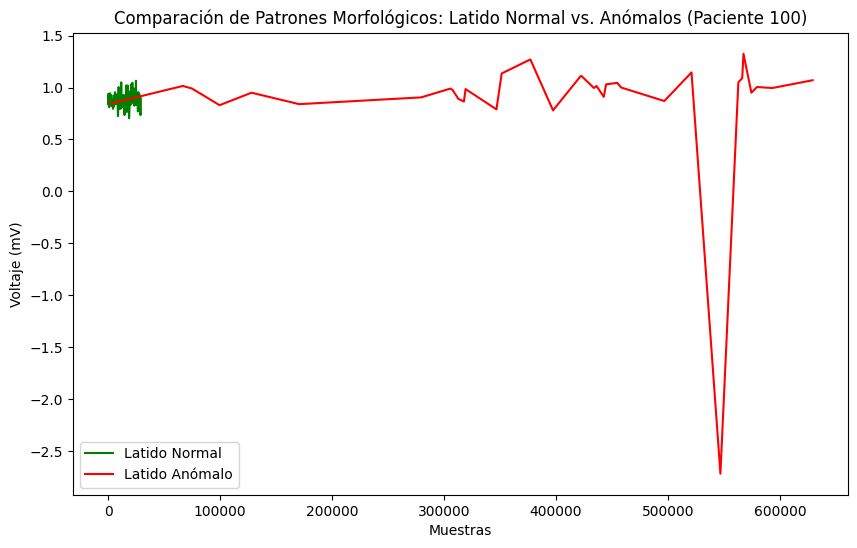

In [19]:
paciente = '100'
# Símbolos de latidos anómalos (todos excepto 'N')
anomalos = [k for k in ann_label.keys() if k != 'N']

normal_beat = df_final[(df_final['Símbolo'] == 'N') & (df_final['Registro'] == paciente)].iloc[:100]
abnormal_beat = df_final[(df_final['Símbolo'].isin(anomalos)) & (df_final['Registro'] == paciente)].iloc[:100]

plt.figure(figsize=(10, 6))
plt.plot(normal_beat['Sample'], normal_beat['MLII'], label='Latido Normal', color='green')
plt.plot(abnormal_beat['Sample'], abnormal_beat['MLII'], label='Latido Anómalo', color='red')
plt.title(f'Comparación de Patrones Morfológicos: Latido Normal vs. Anómalos (Paciente {paciente})')
plt.xlabel('Muestras')
plt.ylabel('Voltaje (mV)')
plt.legend()
plt.savefig(os.path.join(output_dir, f'patrones_morfo_latidos_paciente_{paciente}.png'))
plt.show()
plt.close()

4. Análisis de la dispersión de las señales

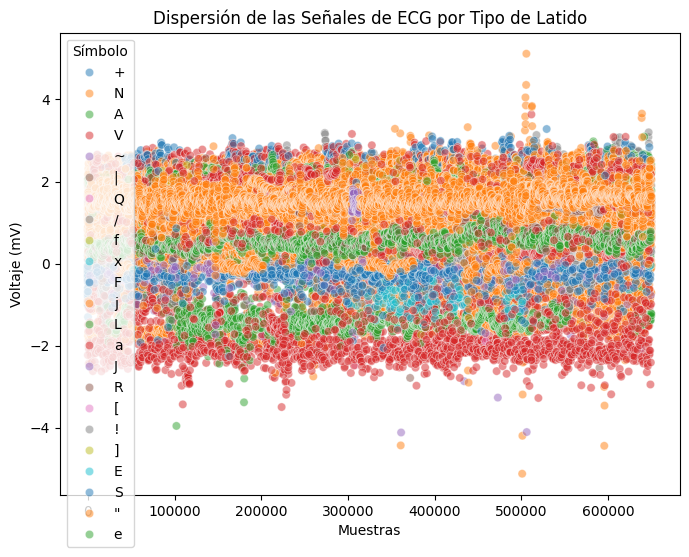

In [21]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Sample', y='MLII', data=df_final, hue='Símbolo', palette='tab10', alpha=0.5)
plt.title('Dispersión de las Señales de ECG por Tipo de Latido')
plt.xlabel('Muestras')
plt.ylabel('Voltaje (mV)')
plt.savefig(os.path.join(output_dir, 'dispercion_senales_ecg.png'))
plt.show()
plt.close()

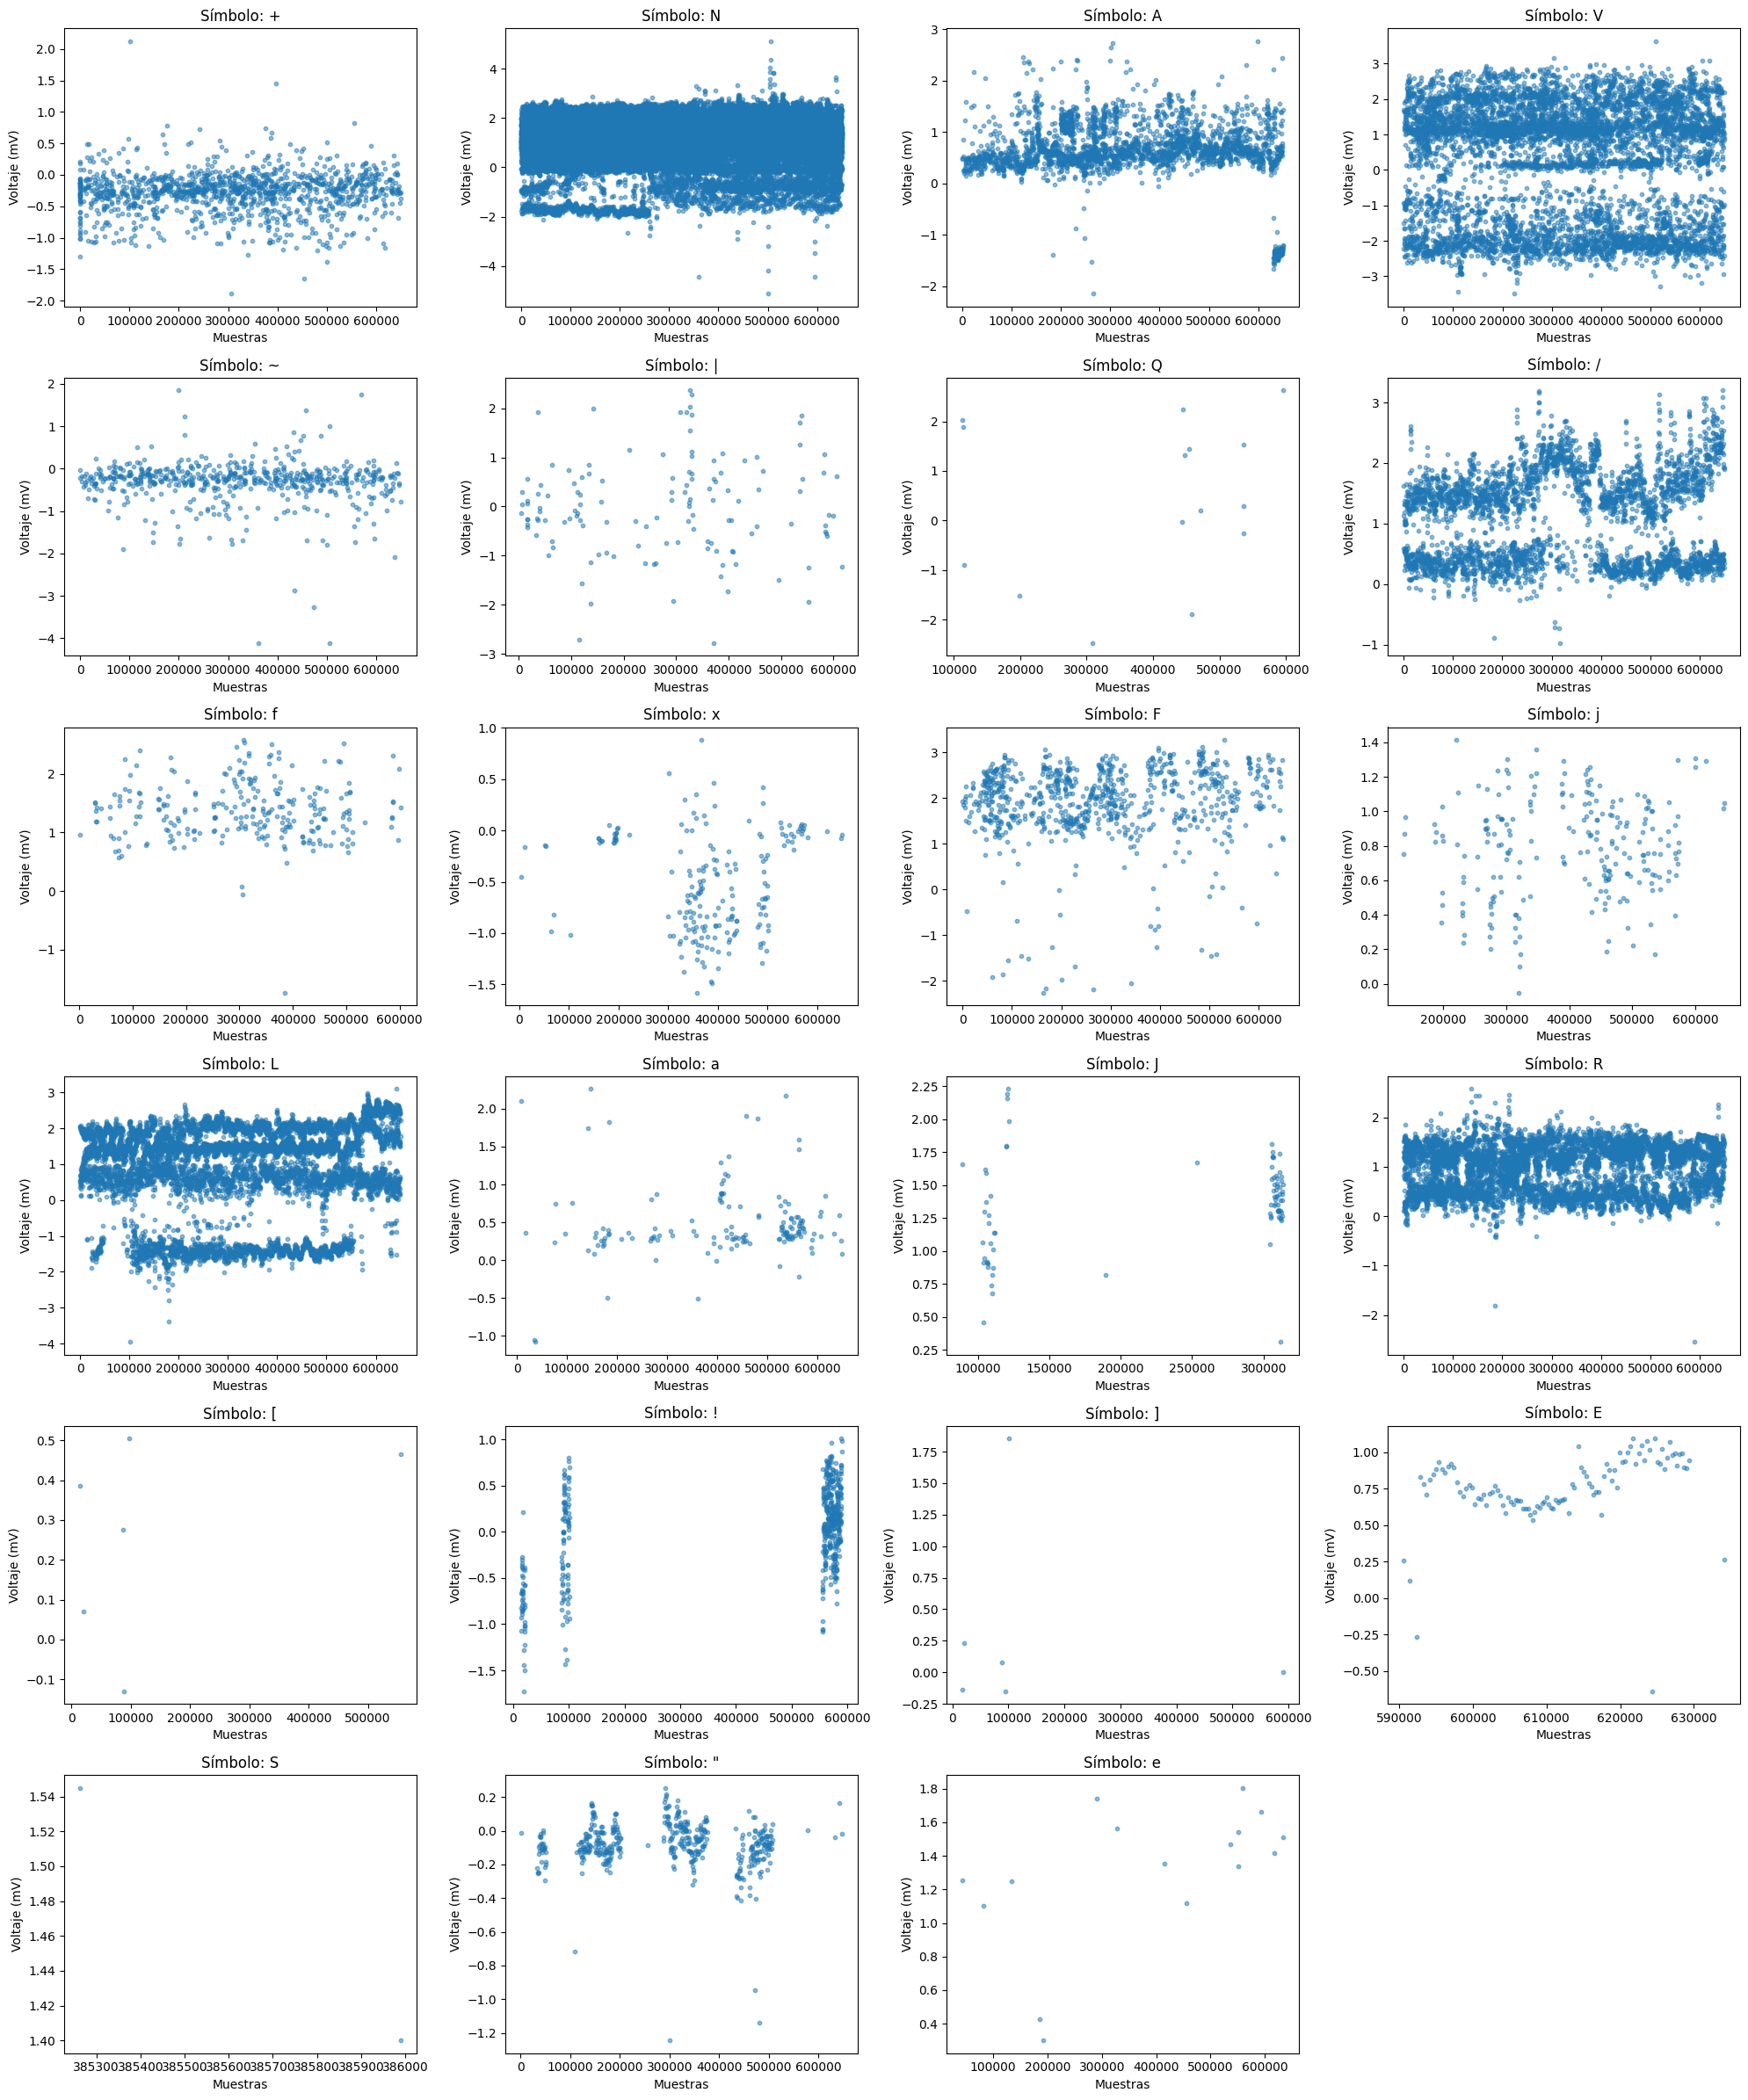

In [29]:
simbolos = df_final['Símbolo'].dropna().unique()
n = len(simbolos)
cols = 4
rows = (n + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))
for i, simbolo in enumerate(simbolos, 1):
    plt.subplot(rows, cols, i)
    subset = df_final[df_final['Símbolo'] == simbolo]
    plt.scatter(subset['Sample'], subset['MLII'], alpha=0.5, s=10)
    plt.title(f'Símbolo: {simbolo}')
    plt.xlabel('Muestras')
    plt.ylabel('Voltaje (mV)')
    plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'dispercion_senales_por_simbolo.png'))
plt.show()
plt.close()

Latidos normales encontrados: 100
Latidos anómalos encontrados: 34
Gráfico guardado en: output\patrones_morfo_latidos_paciente_100.png


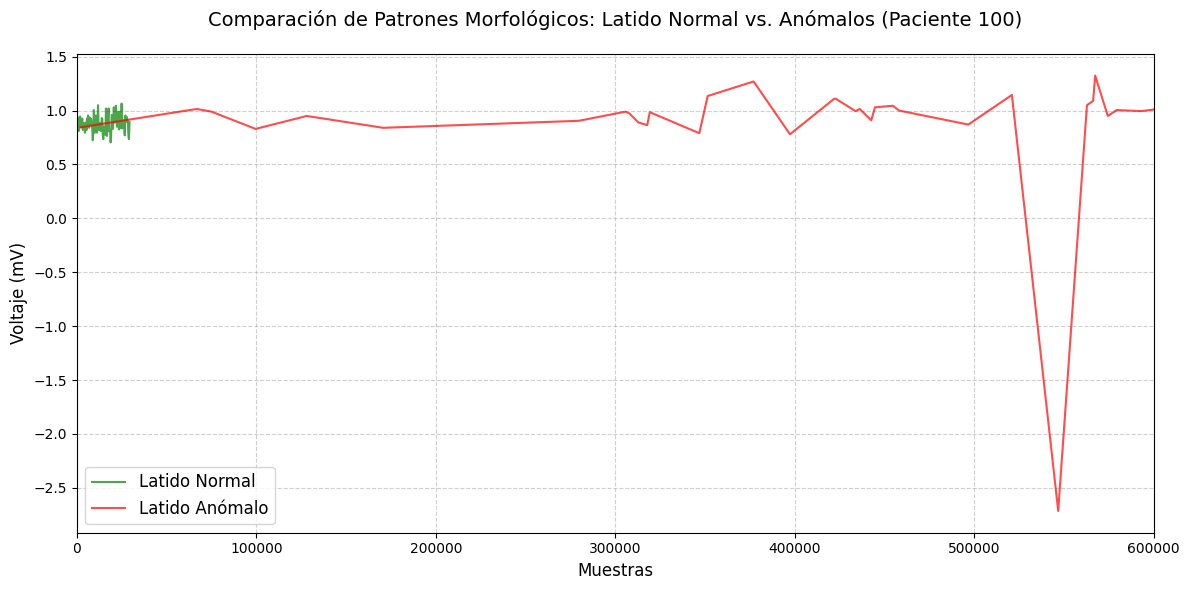

In [22]:
import os
import matplotlib.pyplot as plt
import pandas as pd

def comparar_latidos_paciente(df_final, ann_label, paciente='100', output_dir='output'):
    """
    Compara los patrones morfológicos de latidos normales vs. anómalos para un paciente específico
    y guarda el gráfico resultante.
    
    Parámetros:
        df_final (DataFrame): DataFrame con los datos de los latidos
        ann_label (dict): Diccionario con las anotaciones de los latidos
        paciente (str): ID del paciente a analizar
        output_dir (str): Directorio donde guardar el gráfico
    """
    
    # Crear directorio de salida si no existe
    os.makedirs(output_dir, exist_ok=True)
    
    # Símbolos de latidos anómalos (todos excepto 'N')
    anomalos = [k for k in ann_label.keys() if k != 'N']
    
    # Filtrar latidos normales y anómalos para el paciente
    normal_beat = df_final[(df_final['Símbolo'] == 'N') & (df_final['Registro'] == paciente)].iloc[:100]
    abnormal_beat = df_final[(df_final['Símbolo'].isin(anomalos)) & (df_final['Registro'] == paciente)].iloc[:100]
    
    # Verificar que hay datos suficientes
    if len(normal_beat) == 0:
        print(f"No se encontraron latidos normales para el paciente {paciente}")
        return
    if len(abnormal_beat) == 0:
        print(f"No se encontraron latidos anómalos para el paciente {paciente}")
        return
    
    print(f"Latidos normales encontrados: {len(normal_beat)}")
    print(f"Latidos anómalos encontrados: {len(abnormal_beat)}")
    
    # Configurar el gráfico
    plt.figure(figsize=(12, 6))
    
    # Graficar latidos normales (verde) y anómalos (rojo)
    plt.plot(normal_beat['Sample'], normal_beat['MLII'], 
             label='Latido Normal', color='green', alpha=0.7)
    plt.plot(abnormal_beat['Sample'], abnormal_beat['MLII'], 
             label='Latido Anómalo', color='red', alpha=0.7)
    
    # Configurar título y etiquetas
    plt.title(f'Comparación de Patrones Morfológicos: Latido Normal vs. Anómalos (Paciente {paciente})',
              fontsize=14, pad=20)
    plt.xlabel('Muestras', fontsize=12)
    plt.ylabel('Voltaje (mV)', fontsize=12)
    
    # Configurar ejes y cuadrícula
    plt.xlim(0, 600000)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    
    # Ajustar diseño
    plt.tight_layout()
    
    # Guardar y mostrar
    output_path = os.path.join(output_dir, f'patrones_morfo_latidos_paciente_{paciente}.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Gráfico guardado en: {output_path}")
    plt.show()
    plt.close()

# Ejemplo de uso:
comparar_latidos_paciente(df_final, ann_label, paciente='100')

Latidos normales encontrados: 100
Latidos anómalos encontrados: 2
Gráfico guardado en: output\patrones_morfo_latidos_paciente_103.png


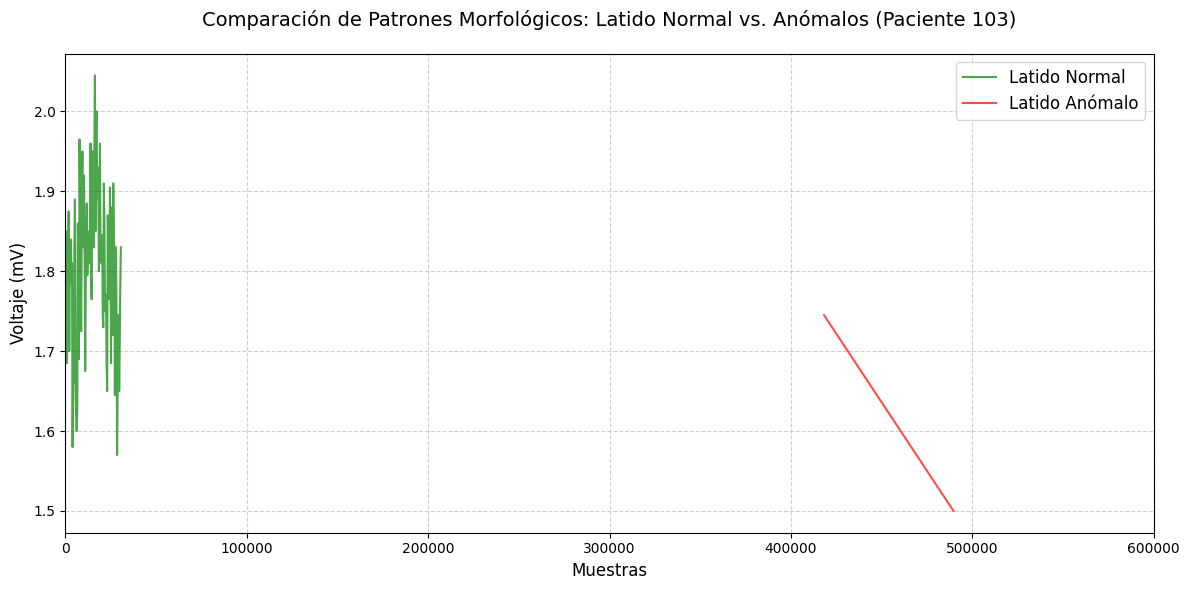

In [23]:
comparar_latidos_paciente(df_final, ann_label, paciente='103')

Latidos normales encontrados: 100
Latidos anómalos encontrados: 46
Gráfico guardado en: output\patrones_morfo_latidos_paciente_105.png


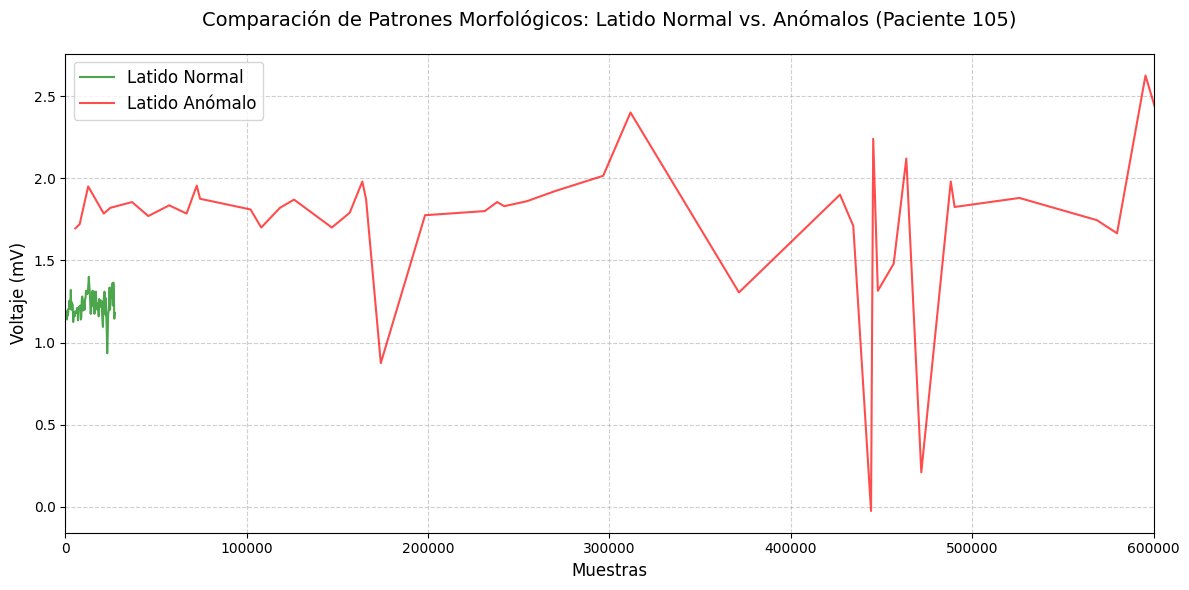

In [24]:
comparar_latidos_paciente(df_final, ann_label, paciente='105')

Latidos normales encontrados: 100
Latidos anómalos encontrados: 100
Gráfico guardado en: output\patrones_morfo_latidos_paciente_116.png


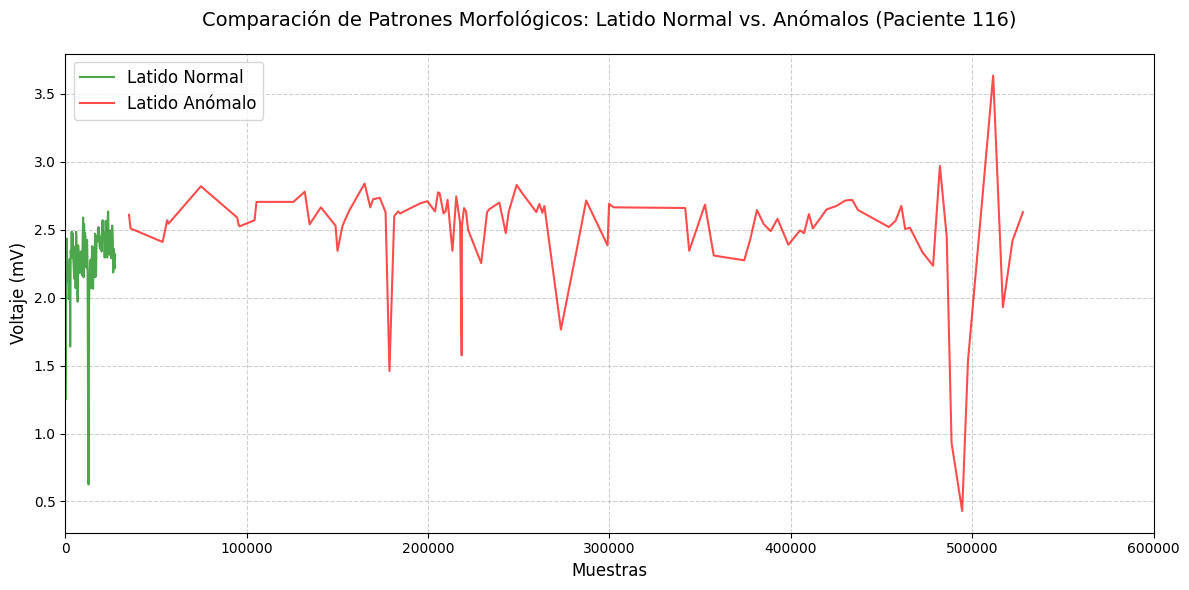

In [28]:
comparar_latidos_paciente(df_final, ann_label, paciente='116')

5. Análisis de la cantidad de datos nulos en las distintas derivaciones

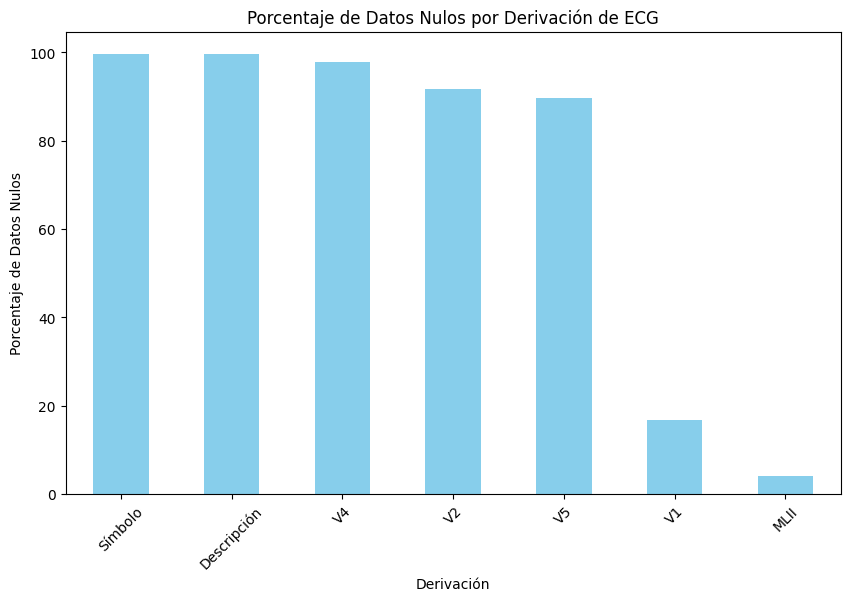

In [31]:
plt.figure(figsize=(10, 6))
missing_data = df_final.isnull().sum() / len(df_final) * 100  # Porcentaje de valores nulos
missing_data = missing_data[missing_data > 0]  # Solo mostrar derivaciones con valores nulos
missing_data.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Porcentaje de Datos Nulos por Derivación de ECG')
plt.xlabel('Derivación')
plt.ylabel('Porcentaje de Datos Nulos')
plt.xticks(rotation=45)
plt.savefig(os.path.join(output_dir, 'porcentaje_datos_nulos.png'))
plt.show()
plt.close()

6. Análisis de la dispersión de los valores de voltaje de la señal ECG (detectar outliers)


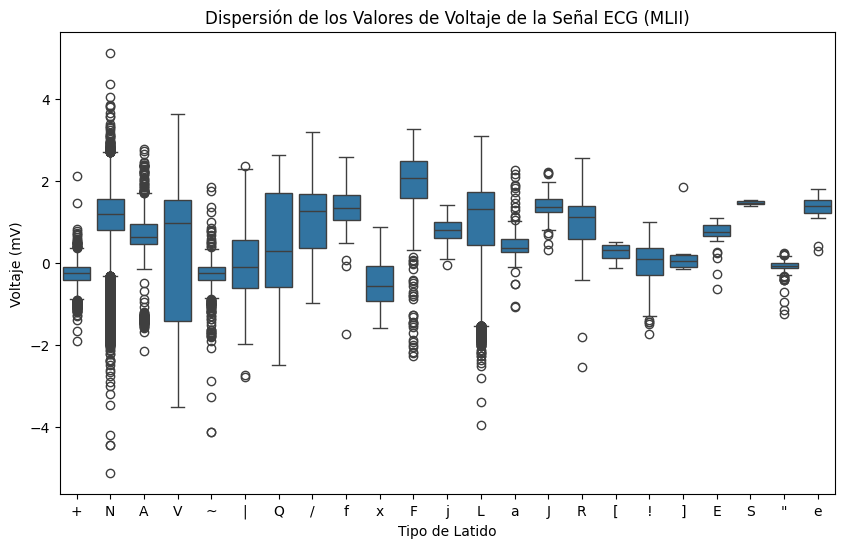

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Símbolo', y='MLII', data=df_final)
plt.title('Dispersión de los Valores de Voltaje de la Señal ECG (MLII)')
plt.xlabel('Tipo de Latido')
plt.ylabel('Voltaje (mV)')
plt.savefig(os.path.join(output_dir, 'dispercion_valores_ecg.png'))
plt.show()
plt.close()

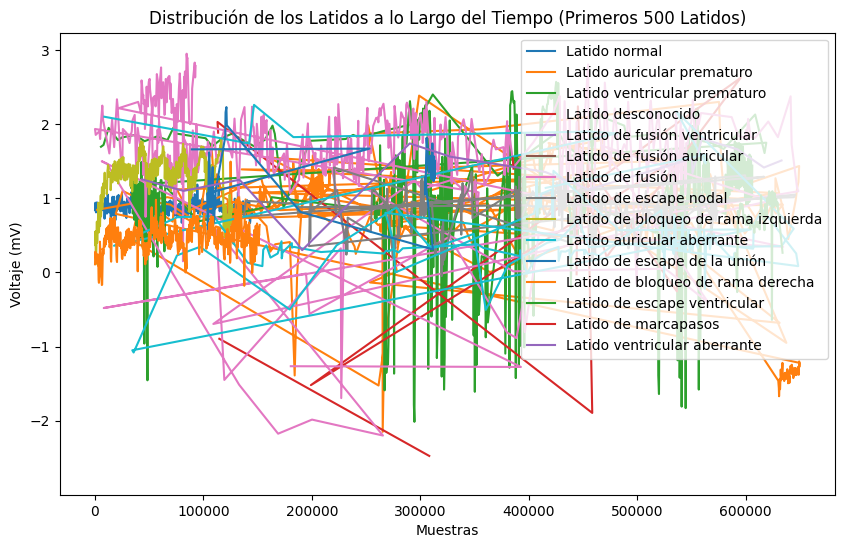

In [35]:
plt.figure(figsize=(10, 6))
for label in df_final['Símbolo'].unique():
    desc = ann_label.get(label, "Desconocido")
    if desc == "Desconocido":
        continue
    subset = df_final[df_final['Símbolo'] == label]
    plt.plot(subset['Sample'][:500], subset['MLII'][:500], label=desc)
plt.title('Distribución de los Latidos a lo Largo del Tiempo (Primeros 500 Latidos)')
plt.xlabel('Muestras')
plt.ylabel('Voltaje (mV)')
plt.legend(loc='upper right')
plt.savefig(os.path.join(output_dir, 'distribucion_latidos_tiempo.png'))
plt.show()
plt.close()

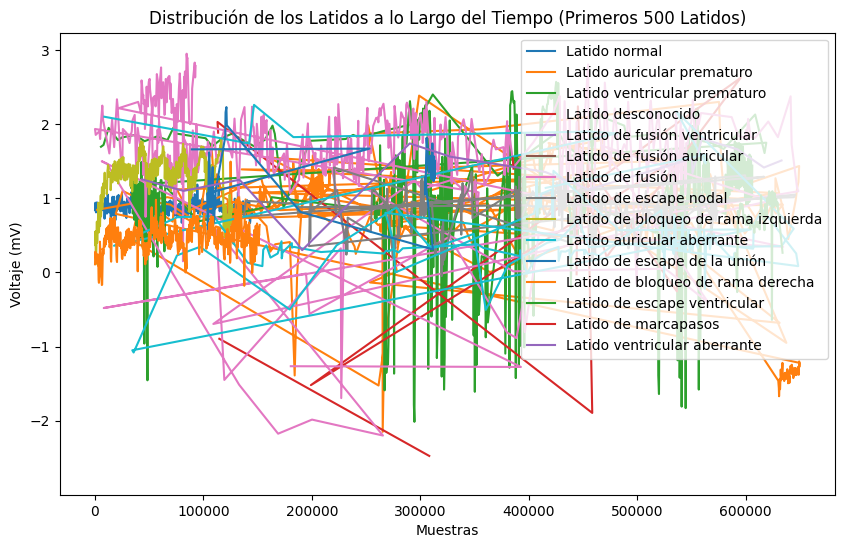

In [ ]:
plt.figure(figsize=(10, 6))
for label in df_final['Símbolo'].unique():
    desc = ann_label.get(label, "Desconocido")
    if desc == "Desconocido":
        continue
    subset = df_final[df_final['Símbolo'] == label]
    plt.plot(subset['Sample'][:500], subset['MLII'][:500], label=desc)
plt.title('Distribución de los Latidos a lo Largo del Tiempo (Primeros 500 Latidos)')
plt.xlabel('Muestras')
plt.ylabel('Voltaje (mV)')
plt.legend(loc='upper right')
plt.savefig(os.path.join(output_dir, 'distribucion_latidos_tiempo.png'))
plt.show()
plt.close()

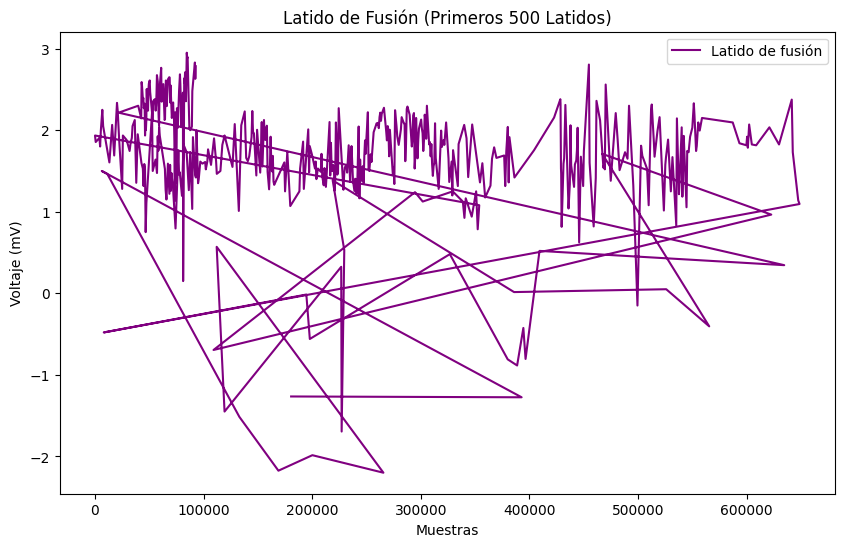

In [37]:
# Graficar solo los latidos de fusión ('F')
fusion_label = 'F'
fusion_desc = ann_label.get(fusion_label, "Desconocido")
fusion_subset = df_final[df_final['Símbolo'] == fusion_label]
if not fusion_subset.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(fusion_subset['Sample'][:500], fusion_subset['MLII'][:500], label=fusion_desc, color='purple')
    plt.title('Latido de Fusión (Primeros 500 Latidos)')
    plt.xlabel('Muestras')
    plt.ylabel('Voltaje (mV)')
    plt.legend()
    plt.show()
else:
    print("No se encontraron latidos de fusión ('F') en el dataset.")

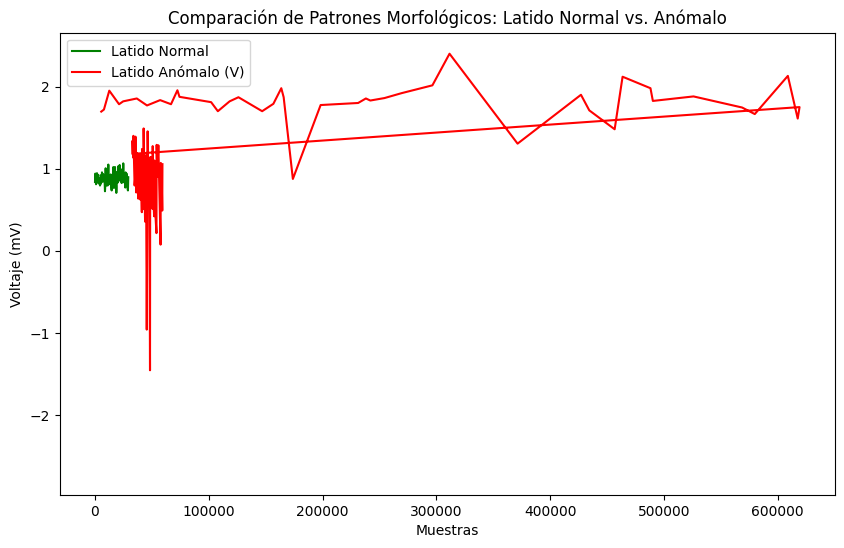

In [38]:
# 8. Comparación de características morfológicas de los latidos normales vs. latidos anómalos
# Seleccionamos una muestra de latidos normales (N) y latidos anómalos (V) para su comparación
normal_beat = df_final[df_final['Símbolo'] == 'N'].iloc[0:100]  # Primeros 100 latidos normales
abnormal_beat = df_final[df_final['Símbolo'] == 'V'].iloc[0:100]  # Primeros 100 latidos ventriculares prematuros

plt.figure(figsize=(10, 6))
plt.plot(normal_beat['Sample'], normal_beat['MLII'], label='Latido Normal', color='green')
plt.plot(abnormal_beat['Sample'], abnormal_beat['MLII'], label='Latido Anómalo (V)', color='red')
plt.title('Comparación de Patrones Morfológicos: Latido Normal vs. Anómalo')
plt.xlabel('Muestras')
plt.ylabel('Voltaje (mV)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'comparacion_morfo_latidos.png'))
plt.show()
plt.close()

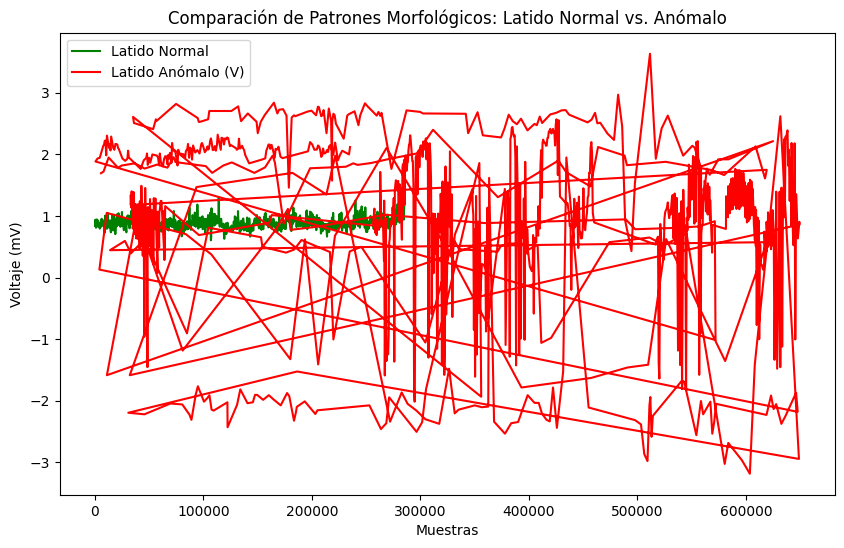

In [39]:
# 8. Comparación de características morfológicas de los latidos normales vs. latidos anómalos
# Seleccionamos una muestra de latidos normales (N) y latidos anómalos (V) para su comparación
normal_beat = df_final[df_final['Símbolo'] == 'N'].iloc[0:1000]  # Primeros 100 latidos normales
abnormal_beat = df_final[df_final['Símbolo'] == 'V'].iloc[0:1000]  # Primeros 100 latidos ventriculares prematuros

plt.figure(figsize=(10, 6))
plt.plot(normal_beat['Sample'], normal_beat['MLII'], label='Latido Normal', color='green')
plt.plot(abnormal_beat['Sample'], abnormal_beat['MLII'], label='Latido Anómalo (V)', color='red')
plt.title('Comparación de Patrones Morfológicos: Latido Normal vs. Anómalo')
plt.xlabel('Muestras')
plt.ylabel('Voltaje (mV)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'comparacion_morfo_latidos.png'))
plt.show()
plt.close()

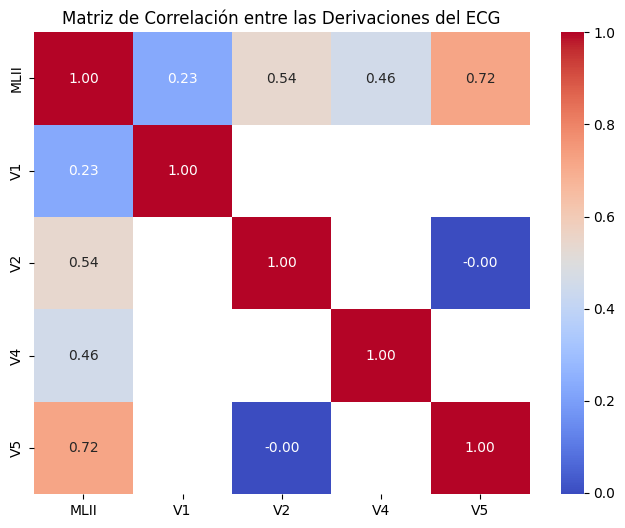

¡Últimas imágenes guardadas en la carpeta 'AED_images'!


In [ ]:
# 9. Gráfico de correlación entre las derivaciones del ECG (por ejemplo, MLII vs V1, MLII vs V5)
correlation_matrix = df_final[['MLII', 'V1', 'V2', 'V4', 'V5']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre las Derivaciones del ECG')
plt.savefig(os.path.join(output_dir, 'correlacion_derivaciones.png'))
plt.show()
plt.close()



C:\Users\pevv2\AppData\Local\Temp\ipykernel_7960\1104557415.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_final, x='Símbolo', order=ann_label.keys(), palette="Set2")


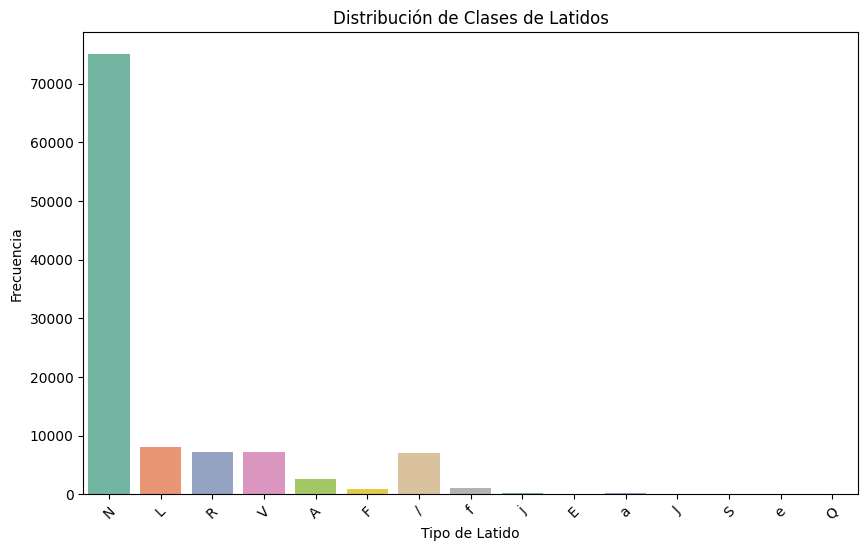

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import butter, filtfilt

# 1. Análisis de Desbalance de Clases
# Visualizar la distribución de clases (N, V, A, L, R, etc.)
plt.figure(figsize=(10, 6))
sns.countplot(data=df_final, x='Símbolo', order=ann_label.keys(), palette="Set2")
plt.title("Distribución de Clases de Latidos")
plt.xlabel("Tipo de Latido")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.show()




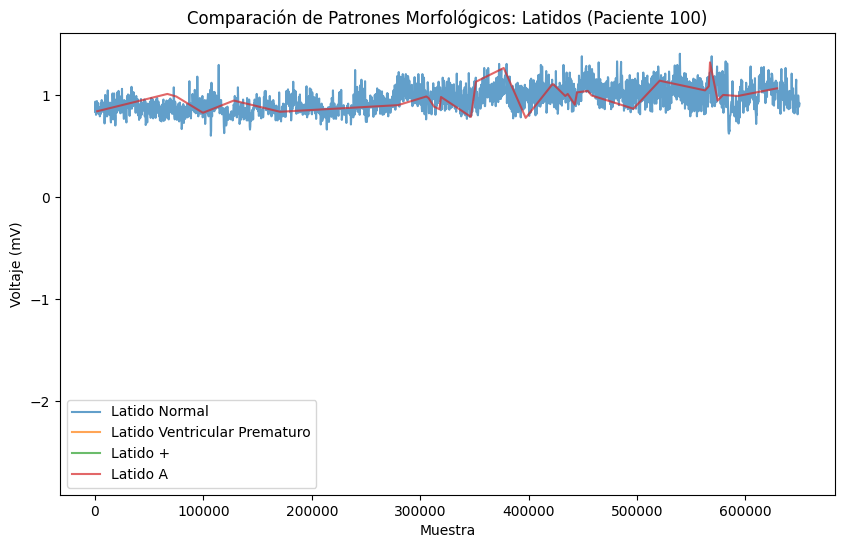

  Símbolo  frecuencia
2       N        2239
1       A          33
0       +           1
3       V           1


In [50]:
# Selecciona el paciente de interés
paciente = '100'

# Filtra latidos normales y VP del mismo paciente
df_latidos_normales_paciente = df_final[(df_final['Símbolo'] == 'N') & (df_final['Registro'] == paciente)]
df_latidos_vp_paciente = df_final[(df_final['Símbolo'] == 'V') & (df_final['Registro'] == paciente)]
# Obtener todos los símbolos presentes para el paciente
simbolos_paciente = df_final[df_final['Registro'] == paciente]['Símbolo'].dropna().unique()

plt.figure(figsize=(10, 6))
# Graficar los latidos normales y ventriculares prematuros del mismo paciente
if not df_latidos_normales_paciente.empty:
    plt.plot(df_latidos_normales_paciente['Sample'][:5000], df_latidos_normales_paciente['MLII'][:5000], label="Latido Normal", alpha=0.7)
if not df_latidos_vp_paciente.empty:
    plt.plot(df_latidos_vp_paciente['Sample'][:5000], df_latidos_vp_paciente['MLII'][:5000], label="Latido Ventricular Prematuro", alpha=0.7)

# Graficar cada tipo de latido del paciente (además de N y V)
for simbolo in simbolos_paciente:
    if simbolo in ['N', 'V']:
        continue
    subset = df_final[(df_final['Registro'] == paciente) & (df_final['Símbolo'] == simbolo)]
    if not subset.empty:
        plt.plot(subset['Sample'][:5000], subset['MLII'][:5000], label=f"Latido {simbolo}", alpha=0.7)

plt.title(f"Comparación de Patrones Morfológicos: Latidos (Paciente {paciente})")
plt.xlabel("Muestra")
plt.ylabel("Voltaje (mV)")
plt.legend()
plt.show()

# Opcional: Análisis de frecuencia solo para el paciente
frecuencia_latidos_paciente = df_final[df_final['Registro'] == paciente].groupby('Símbolo').size().reset_index(name='frecuencia').sort_values(by='frecuencia', ascending=False)
print(frecuencia_latidos_paciente)